In [100]:
import numpy
from matplotlib import pyplot
from numpy.random import default_rng
from scipy.stats import wasserstein_distance
import matplotlib
import matplotlib.pyplot as plt


def get_fragment_indices(fragment, min_length):
    while True:
        indices_count = fragment.shape[0]
        start_index = numpy.random.randint(indices_count)
        for end_index in range(start_index, indices_count):
            if fragment[end_index] - fragment[start_index] > min_length:
                indices = numpy.array(list(range(start_index, end_index+1)))
                return indices


def match_fragments(full_fragment, partial_fragment):
    full_fragment_length = numpy.max(full_fragment)
    partial_fragment_length = numpy.max(partial_fragment)
    start_pos = 0
    end_pos = partial_fragment_length
    delta = 0.00001
    max_dist = numpy.inf
    matched_indices = None
    while end_pos < 1:
        # indices = numpy.where(numpy.any((full_fragment > start_pos) and (full_fragment < end_pos)))
        # indices = numpy.where(numpy.any(full_fragment > start_pos))
        index_predicates = (full_fragment > start_pos) & (full_fragment < end_pos)
        indices = numpy.where(index_predicates)[0]
        indices.sort()

        current_fragment = full_fragment[indices]
        current_fragment = current_fragment - current_fragment[0]

        dist = wasserstein_distance(current_fragment, partial_fragment)
        if dist < max_dist:
            max_dist = dist
            matched_indices = indices

        end_pos = end_pos + delta
        start_pos = start_pos + delta

    return matched_indices

In [101]:
size = 100
rng = default_rng(seed=0)
full_fragment = rng.uniform(size=size)
full_fragment.sort()

partial_fragment_indices = get_fragment_indices(fragment=full_fragment, min_length=0.1)
partial_fragment = full_fragment[partial_fragment_indices]
sampling_factor = 0.8
sampled_partial_fragment_size = int(partial_fragment_indices.shape[0] * sampling_factor)
sampled_partial_fragment_meta_indices = numpy.random.choice(partial_fragment_indices.shape[0], sampled_partial_fragment_size, replace=False)
sampled_partial_fragment_meta_indices.sort()

sampled_partial_fragment_indices = partial_fragment_indices[sampled_partial_fragment_meta_indices]
sampled_partial_fragment = full_fragment[sampled_partial_fragment_indices]
sampled_partial_fragment.sort()

min_scale = 0.95
max_scale = 1.05
scale = (max_scale - min_scale) * numpy.random.random(1) + min_scale
# scale = 1

transformed_sampled_partial_fragment = scale * (sampled_partial_fragment - sampled_partial_fragment[0])
matched_indices = match_fragments(full_fragment=full_fragment, partial_fragment=transformed_sampled_partial_fragment)
matched_fragment = full_fragment[matched_indices]

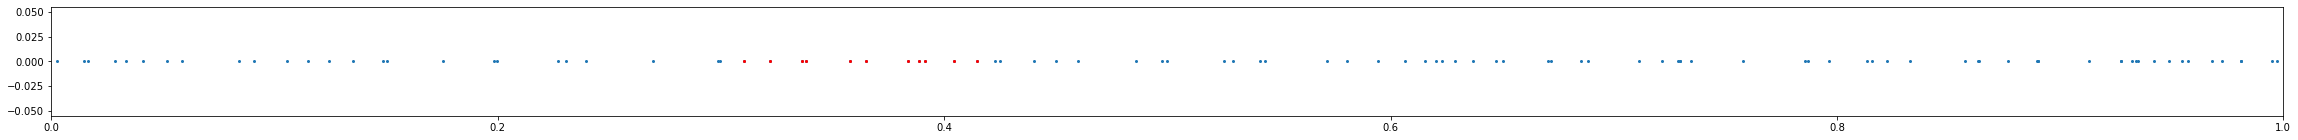

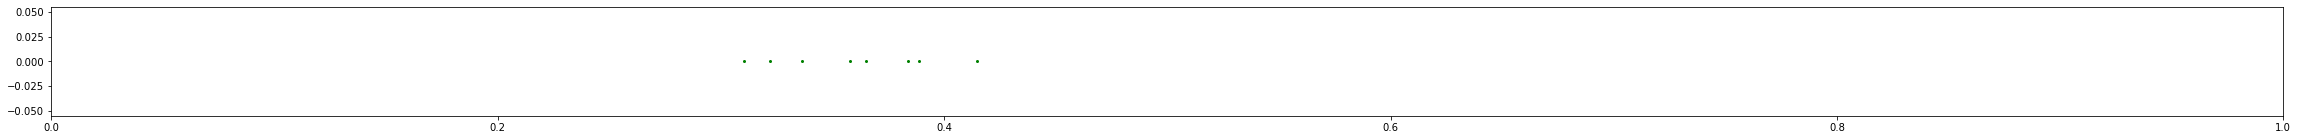

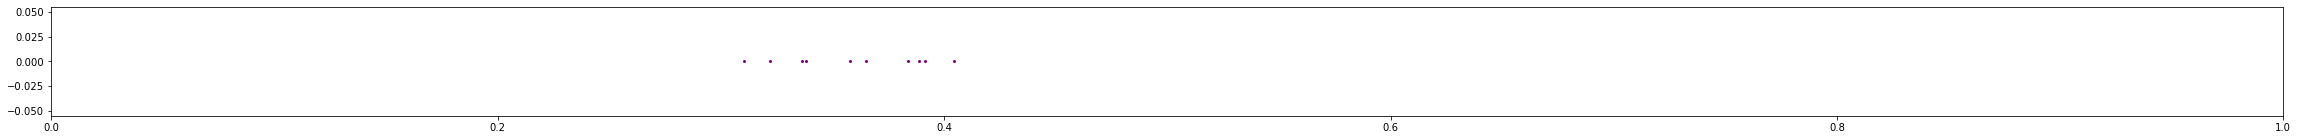

In [102]:
plt.figure(figsize=(40,2))
y1 = numpy.zeros_like(full_fragment)
x1 = full_fragment
plt.plot(x1, y1, 'o', markersize=2)

y2 = numpy.zeros_like(partial_fragment)
x2 = partial_fragment
plt.plot(x2, y2, 'o', markersize=2, markerfacecolor='red', markeredgecolor='red')

# y3 = numpy.zeros_like(sampled_partial_fragment)
# x3 = sampled_partial_fragment
# plt.plot(x3, y3, 'o', markersize=2, markerfacecolor='green', markeredgecolor='green')
plt.xlim(0, 1)
plt.show()

plt.figure(figsize=(40,2))
y3 = numpy.zeros_like(sampled_partial_fragment)
x3 = sampled_partial_fragment
plt.plot(x3, y3, 'o', markersize=2, markerfacecolor='green', markeredgecolor='green')
plt.xlim(0, 1)
plt.show()

plt.figure(figsize=(40,2))
y4 = numpy.zeros_like(matched_fragment)
x4 = matched_fragment
plt.plot(x4, y4, 'o', markersize=2, markerfacecolor='purple', markeredgecolor='purple')
plt.xlim(0, 1)
plt.show()